# Libraries and Data Import
Also have a quick look at the data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
repository_directory = "../"
construct_df_hd_model = True

# Data Import

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, cross_val_score

Decision tree, RFC, xgboost, other boost, ensemble mothod, NB


In [10]:
file_path = repository_directory + "data/" +"ST4000DM000_processed_relevant" 
print(file_path)
df_d = pd.read_csv(file_path, parse_dates=["date"])

../data/ST4000DM000_processed_relevant


# Some useful functions and lists

In [11]:
# specify commonly used column names
column_name_all = df_d.columns
column_name_basic, column_name_smart = column_name_all[:5], column_name_all[5:]
column_name_smart_raw = pd.Index([c for c in column_name_smart if "raw" in c ])
column_name_smart_normalized = pd.Index([c for c in column_name_smart if "normalized" in c ])

# collections of important smart parameters from different sources
key_smart_backblaze = [5, 187, 188, 197, 198] # https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/
key_smart_wiki = [5, 10, 184, 187, 188, 196, 197, 198, 201] # https://en.wikipedia.org/wiki/S.M.A.R.T.
key_smart_ai_paper = [3, 5, 7, 187, 188, 190, 197, 198] # https://www.sciencedirect.com/science/article/pii/S2666827021000219
key_smart_power_on_time = [9]
key_smart_group = [5, 183, 184, 187]

# choose smart and set up the column name 
key_smart = [5, 183, 184, 187]
column_name = pd.Index(list(column_name_basic) + ["smart_" + str(i) + "_" + "raw" for i in key_smart])
print(column_name)

def smart2meaningful(col):
    """smart to meaningful names
    see wiki for more info: https://en.wikipedia.org/wiki/S.M.A.R.T.

    Args:
        col (panda.Index): name of columns returned from a dataframe

    Returns:
        panda.Index: a column with more meaningful names
    """
    dict_smart = {3   : "spin_up_time",
                  5   : "reallocated_sector_count", # or "bad-sector count" 
                  7   : "seek_error_rate", # or "reading-head seek-error rate", vendor-dependent
                  9   : "power_on_time", 
                  10  : "spin_retry_count",
                  183 : "downshift_error_count", #  another possible meaning is: Runtime Bad Block
                  184 : "end_to_end_error", # vendor-dependent
                  187 : "reported_uncorrectable_error",
                  188 : "command_timeout_count",
                  190 : "temperature_special", # vendor-dependent
                  194 : "temperature",
                  196 : "reallocation_event_count",
                  197 : "current_pending_sector_count", # or "unusable sector count"
                  198 : "uncorrectable_sector_count", 
                  201 : "software_read_error_count", 
                  231 : "expected_life_left"
    }
    col_modified = []
    for name in list(col):
        if "smart_" in name:
            number = int(name.split("smart_")[1].split("_")[0])
            if number in list(dict_smart.keys()):
                col_modified.append(name.replace("smart_" + str(number), dict_smart[number]))
            else:
                col_modified.append(name)
        else:
            col_modified.append(name)
    return pd.Index(col_modified)

# change the smart name into meaningful names for a dataframe
# this should be applied only after you perform all operations on columns
def smart2meaningful_for_dataframe(df):
    df.columns = smart2meaningful(df.columns)
    return df

# drop all smart columns except those specified by smart_to_keep
def keep_some_smart_column_for_dataframe(df, smart_to_keep=[], raw_or_normalized="raw"):
    cols = df.columns
    cols_nonsmart = [col for col in cols if not "smart_" in col]
    #cols_smart = [col for col in cols if "smart_" in col]
    #s = set(cols_smart)
    cols_smart = ["smart_" + str(i) + "_" + raw_or_normalized for i in smart_to_keep]
    return df[cols_nonsmart + cols_smart]

def change_feature_dtype_for_dataframe(df, feature_to_change=[]):
    col = df.columns
    for feature in feature_to_change:
        if not feature in col:
            print("### Error!")
            print(f"### The feature '{feature}' is not found in the dataframe '{df}'!")
            print("### Partially modified dataframe is returned!")
            return df
        if feature == "failure":
            df.astype({feature : "int64"})
        elif feature == "date":
            df[feature] = pd.to_datetime(df[feature], format='%Y-%m-%d')
    return df

# create features for a dataframe
def create_features_for_dataframe(df, features_to_create=[], drop=False):
    feature_to_drop = []
    col = df.columns
    for feature in features_to_create:
        if feature == "capacity_gb":
            features_needed = ["capacity_bytes"]
            for feature_needed in features_needed:
                if not feature_needed in col:
                    print("### Error!")
                    print(f"### Cannot create '{feature}' because the required feature '{feature_needed}' is not found in the dataframe '{df}'!")
                    print("### Partially modified dataframe is returned!")
                    return df
            gb2byte = 1024**3
            df[feature] = df[features_needed[0]].apply(lambda x : int(x)/gb2byte)
            feature_to_drop.append(*features_needed)
        #elif feature == "power_on_time_day":
        #    df[feature] = df["power_on_time"].apply(lambda x : x/24)
        #    feature_to_drop.append("power_on_time")
    if drop:
        df.drop(list(set(feature_to_drop)), axis=1, inplace=True)
    return df

Index(['date', 'serial_number', 'model', 'failure', 'smart_1_normalized',
       'smart_5_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw'],
      dtype='object')


In [12]:
file_path = repository_directory + "data/" +"ST4000DM000_processed_relevant" 
print(file_path)
df = pd.read_csv(file_path, parse_dates=["date"])
df = keep_some_smart_column_for_dataframe(df_d, smart_to_keep=key_smart, raw_or_normalized="raw")
df.head(5)

../data/ST4000DM000_processed_relevant


,date,serial_number,model,failure,date_failure,countdown,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
0,2020-09-15,Z304KBK4,ST4000DM000,0,2021-12-16,457.0,0.0,0.0,0.0,0.0
1,2020-09-15,Z304JGH0,ST4000DM000,0,2021-01-14,121.0,0.0,0.0,0.0,0.0
2,2020-09-15,Z302SYHL,ST4000DM000,0,2021-05-22,249.0,0.0,4.0,0.0,33.0
3,2020-09-15,S3010L7K,ST4000DM000,0,2020-12-11,87.0,0.0,2.0,0.0,0.0
4,2020-09-15,Z304JM6A,ST4000DM000,0,2021-01-24,131.0,0.0,0.0,0.0,0.0


## Train-Test Split

We will split the data according to serial numbers

In [13]:
RSEED = 200
serial_number_train, serial_number_test, dummy_train, dummy_test = train_test_split(df_d["serial_number"].unique(), df_d["serial_number"].unique(), test_size=0.2, random_state=RSEED)
serial_number_train = pd.Series(serial_number_train)
serial_number_test = pd.Series(serial_number_test)

df_train = df[ df["serial_number"].isin(serial_number_train)]
y_train = df_train["countdown"]
X_train = df_train.drop("countdown", axis=1)
df_test = df[ df["serial_number"].isin(serial_number_test)]
y_test = df_test["countdown"]
X_test = df_test.drop("countdown", axis=1)

print("number of failure observed in train:", df_train.query("failure == 1")["failure"].count(), "over",df_train.query("failure == False")["failure"].count())
print("number of failure observed in test:", df_test.query("failure == 1")["failure"].count(), "over",df_test.query("failure == 0")["failure"].count())

print("number of unique disk in data:", df["serial_number"].nunique())
print("number of unique disk in train:", df_train["serial_number"].nunique())
print("number of unique disk in test:", df_test["serial_number"].nunique())


number of failure observed in train: 488 over 194235
number of failure observed in test: 122 over 47025
number of unique disk in data: 608
number of unique disk in train: 486
number of unique disk in test: 122


<AxesSubplot:xlabel='countdown', ylabel='smart_5_raw'>

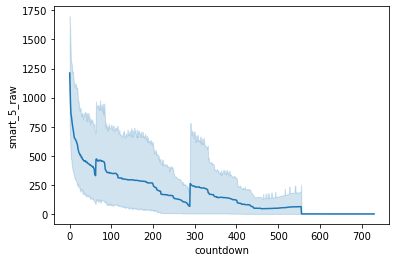

In [14]:
sns.lineplot(data=df_train, x="countdown", y="smart_5_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_183_raw'>

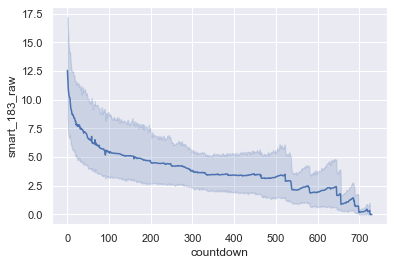

In [ ]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_183_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_184_raw'>

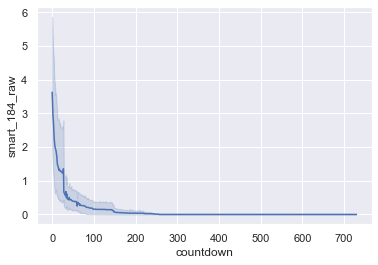

In [ ]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_184_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_187_raw'>

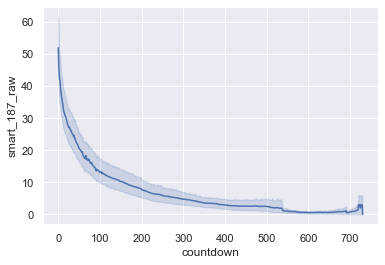

In [ ]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_187_raw", estimator="mean")

<AxesSubplot:xlabel='countdown', ylabel='smart_5_raw'>

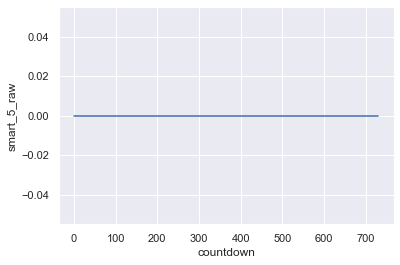

In [ ]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_5_raw", estimator=np.median)

<AxesSubplot:xlabel='countdown', ylabel='smart_183_raw'>

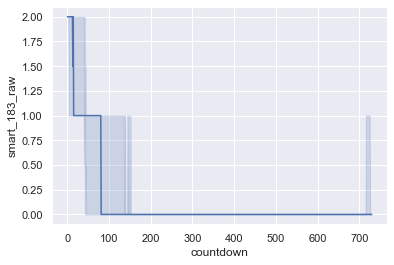

In [ ]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_183_raw", estimator=np.median)

<AxesSubplot:xlabel='countdown', ylabel='smart_184_raw'>

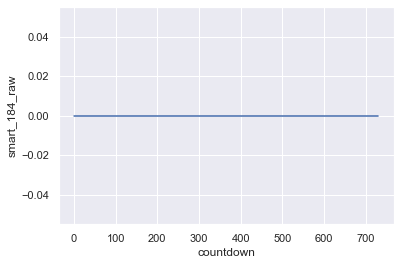

In [ ]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_184_raw", estimator=np.median)

<AxesSubplot:xlabel='countdown', ylabel='smart_187_raw'>

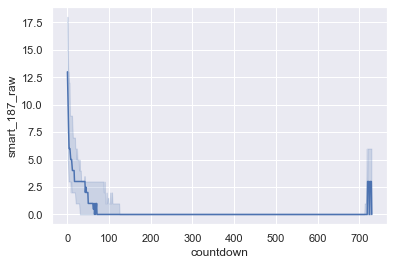

In [ ]:
sns.lineplot(data=df_d_train, x="countdown", y="smart_187_raw", estimator=np.median)

## Baseline Model

In [38]:
def baseline_failure_prediction(features):
    s5r = features["smart_5_raw"]
    s183r = features["smart_183_raw"]
    s184r = features["smart_184_raw"]
    s187r = features["smart_187_raw"]
    #if s5r >= 1.0 and s183r >= 5 and s184r >= 1 and s187r >= 20:
    if s5r >= 1.0 or s183r >= 1 or s184r >= 1 or s187r >= 2:
        return True
    return False

days_before_failure = 30
def get_truth(features, days=days_before_failure):
    if features["countdown"] <= days:
        return 1
    return 0

transform y_train and y_test to classification results (True and False):

In [37]:

y_train_c = y_train.apply(lambda x : 1 if x <= days_before_failure else 0)
y_test_c = y_test.apply(lambda x : 1 if x <= days_before_failure else 0)

make predictions on train and test data:

In [39]:
y_train_c_pred = X_train.apply(baseline_failure_prediction, axis=1)
y_test_c_pred = X_test.apply(baseline_failure_prediction, axis=1)

print out confusion matrix, classification reports, and ROC-AUC score:

# Confusion matrix for train data(log10 scale):


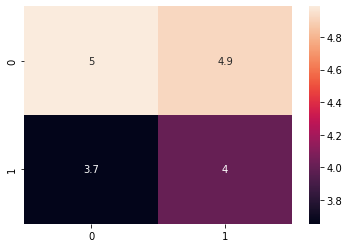

In [18]:
print("# Confusion matrix for train data(log10 scale):")
ax1 = sns.heatmap(np.log10(confusion_matrix(y_train_c, y_train_c_pred)), annot=True)

# Confusion matrix for test data(log10 scale):


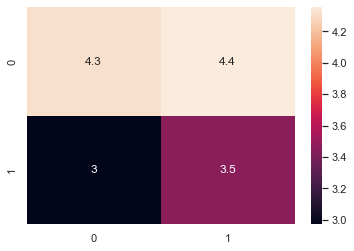

In [ ]:
print("# Confusion matrix for test data(log10 scale):")
ax2 = sns.heatmap(np.log10(confusion_matrix(y_test_c, y_test_c_pred)), annot=True)

In [19]:
print("classification report for train data:")
print(classification_report(y_train_c, y_train_c_pred))
print("classification report for test data:")
print(classification_report(y_test_c, y_test_c_pred))


classification report for train data:
              precision    recall  f1-score   support

       False       0.96      0.54      0.69    180121
        True       0.11      0.69      0.19     14602

    accuracy                           0.55    194723
   macro avg       0.53      0.62      0.44    194723
weighted avg       0.89      0.55      0.65    194723

classification report for test data:
              precision    recall  f1-score   support

       False       0.96      0.48      0.64     43382
        True       0.11      0.75      0.19      3765

    accuracy                           0.50     47147
   macro avg       0.53      0.61      0.42     47147
weighted avg       0.89      0.50      0.60     47147



In [40]:
print("roc auc score for train:", roc_auc_score(y_train_c, y_train_c_pred).round(4))
print("roc auc score for test:", roc_auc_score(y_test_c, y_test_c_pred).round(4))
print("f2 score:", fbeta_score(y_test_c, y_test_c_pred, beta=2).round(4))


roc auc score for train: 0.6155
roc auc score for test: 0.6145
f2 score: 0.3488


In [41]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)



# Define fbeta score with higher weighted recall
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# Define dictionary with several interesting metrics
scorer_dict = {"ftwo_scorer": make_scorer(fbeta_score, beta=0.5), "accuracy": "accuracy", "precision": "precision", "recall": "recall"}

def model_evaluation(clf, scoring, X_train, y_train):
    
    results = {}
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    results = {key: [value.mean().round(4), value.std().round(4)] for key, value in scores.items()}
    
    del results['fit_time']
    del results['score_time']
    
    return results



#Test different types of models
list_of_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(random_state=RSEED)]
for clf in list_of_clf:
    results = model_evaluation(clf, scorer_dict, X_train, y_train_c)
    print(clf)
    print("Accuracy  (mean, std):", results["test_accuracy"])
    print("Recall    (mean, std):", results["test_recall"])
    print("Precision (mean, std):", results["test_precision"])
    print("Fbeta     (mean, std):", results["test_ftwo_scorer"])
    print("----"*10)

/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/base.py", line 581, i

LogisticRegression()
Accuracy  (mean, std): [nan, nan]
Recall    (mean, std): [nan, nan]
Precision (mean, std): [nan, nan]
Fbeta     (mean, std): [nan, nan]
----------------------------------------


/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/neighbors/_base.py", lin

KNeighborsClassifier()
Accuracy  (mean, std): [nan, nan]
Recall    (mean, std): [nan, nan]
Precision (mean, std): [nan, nan]
Fbeta     (mean, std): [nan, nan]
----------------------------------------


/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_da

SVC()
Accuracy  (mean, std): [nan, nan]
Recall    (mean, std): [nan, nan]
Precision (mean, std): [nan, nan]
Fbeta     (mean, std): [nan, nan]
----------------------------------------
DecisionTreeClassifier(random_state=200)
Accuracy  (mean, std): [nan, nan]
Recall    (mean, std): [nan, nan]
Precision (mean, std): [nan, nan]
Fbeta     (mean, std): [nan, nan]
----------------------------------------


/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 165, in fit
    X, y =

# Logistic Regression

We could observe the data and decide which scaler to use:

In [24]:
df_train.head(3)

,date,serial_number,model,failure,date_failure,countdown,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
0,2020-09-15,Z304KBK4,ST4000DM000,0,2021-12-16,457.0,0.0,0.0,0.0,0.0
2,2020-09-15,Z302SYHL,ST4000DM000,0,2021-05-22,249.0,0.0,4.0,0.0,33.0
3,2020-09-15,S3010L7K,ST4000DM000,0,2020-12-11,87.0,0.0,2.0,0.0,0.0


In [25]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
failure,194723.0,0.002506,0.049999,0.0,0.0,0.0,0.0,1.0
countdown,194723.0,257.649425,176.142010,0.0,108.0,232.0,387.0,730.0
smart_5_raw,194723.0,242.197830,2826.184588,0.0,0.0,0.0,0.0,65064.0
smart_183_raw,194723.0,4.816303,30.303931,0.0,0.0,0.0,2.0,720.0
smart_184_raw,194723.0,0.259810,5.536955,0.0,0.0,0.0,0.0,256.0
smart_187_raw,194723.0,8.622392,35.054139,0.0,0.0,0.0,3.0,940.0


It looks like a log transformation would be nice for all of the smart features.

In [26]:
X_train_lr = df_d_train.iloc[:, 6:].apply(lambda x : np.log10(x+1))
y_train_lr = df_d_train["countdown"]
y_train_lr_c = y_train_lr.apply(lambda x : True if x <= days_before_failure else False)
X_test_lr = df_d_test.iloc[:, 6:].apply(lambda x : np.log10(x+1))
y_test_lr = df_d_test["countdown"]
y_test_lr_c = y_test_lr.apply(lambda x : True if x <= days_before_failure else False)


NameError: name 'df_d_train' is not defined

Now we can have a look at the distribution again at the transformed data

In [ ]:
X_train_lr.describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,194723.0,0.152176,0.641353,0.0,0.0,0.0,0.000000,4.813347
smart_183_raw,194723.0,0.267655,0.439204,0.0,0.0,0.0,0.477121,2.857935
smart_184_raw,194723.0,0.009223,0.112938,0.0,0.0,0.0,0.000000,2.409933
smart_187_raw,194723.0,0.370079,0.584697,0.0,0.0,0.0,0.602060,2.973590


Perform scaling with Normalizer

In [ ]:
scaler_lr = Normalizer()
X_train_lr = scaler_lr.fit_transform(X_train_lr)
X_test_lr = scaler_lr.transform(X_test_lr)

Instanciate logistic regression and do predictions for train and test data

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train_lr, y_train_lr_c)
y_train_lr_c_pred = model_lr.predict(X_train_lr)
y_test_lr_c_pred = model_lr.predict(X_test_lr)

In [ ]:
type(y_train_lr_c_pred)
a = pd.Series(y_train_lr_c_pred)
a.value_counts()

False    194723
dtype: int64

# Confusion matrix for train data(log10 scale):


/var/folders/4f/mz1b5sg57p7324fdvfrshs1c0000gn/T/ipykernel_43198/1227641618.py:2: RuntimeWarning: divide by zero encountered in log10
  ax1 = sns.heatmap(np.log10(confusion_matrix(y_train_lr_c, y_train_lr_c_pred)), annot=True)


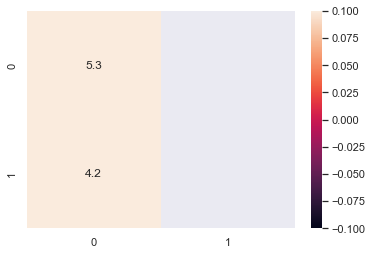

In [ ]:
print("# Confusion matrix for train data(log10 scale):")
ax1 = sns.heatmap(np.log10(confusion_matrix(y_train_lr_c, y_train_lr_c_pred)), annot=True)

In [ ]:
print("classification report for train data:")
print(classification_report(y_train_lr_c, y_train_lr_c_pred))
print("classification report for test data:")
print(classification_report(y_test_lr_c, y_test_lr_c_pred))

classification report for train data:
              precision    recall  f1-score   support

       False       0.93      1.00      0.96    180121
        True       0.00      0.00      0.00     14602

    accuracy                           0.93    194723
   macro avg       0.46      0.50      0.48    194723
weighted avg       0.86      0.93      0.89    194723

classification report for test data:
              precision    recall  f1-score   support

       False       0.92      1.00      0.96     43382
        True       0.00      0.00      0.00      3765

    accuracy                           0.92     47147
   macro avg       0.46      0.50      0.48     47147
weighted avg       0.85      0.92      0.88     47147



/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cmw/hdd-anomaly-detection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

array([2, 1, 0])

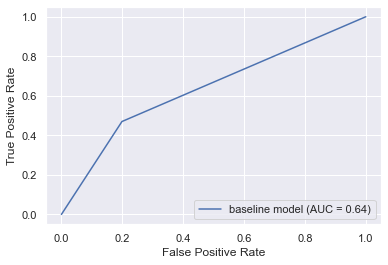

In [ ]:
sns.set(rc={'figure.facecolor': "white"})
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='baseline model')
display.plot()
plt.show()

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)